In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as D
from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from IPython.display import clear_output

from torch.distributions import Normal, Independent, Categorical, MixtureSameFamily

In [11]:
np.random.seed(0)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

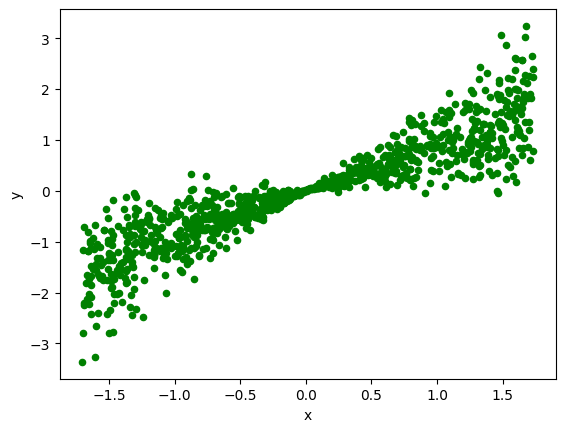

In [13]:
n = 1000
X = np.random.uniform(0, 10, size=(n, 1)).astype(np.float32)
y = (2 * X + 1 + np.random.normal(0, 1, size=(n, 1)) * (X - 5)).astype(
    np.float32
)  # Heteroscedasticity
#y = (2 * X + 1 + 3*np.random.normal(0, 1, size=(n, 1))).astype(
#    np.float32
#)  # Heteroscedasticity


X = (X - X.mean()) / X.std()
y = (y - y.mean()) / y.std()

data = pd.DataFrame({"x": X.squeeze(), "y": y.squeeze()}).plot(
    kind="scatter", x="x", y="y", color="green"
);


In [14]:
X_torch = torch.from_numpy(X).to(device=device)
y_torch = torch.from_numpy(y).to(device=device)

In [15]:
def create_gmm(num_params, sigmas, weights, device=device):
    """
    Creates a Gaussian Mixture Model (GMM) of multivariate normal of size num_params with mean 0 and standard deviations provided by sigmas.

    Args:
        num_params (int): The number of parameters.
        sigmas (list of float): Standard deviations for the Gaussian components.
        weights (list of float): Mixture weights for each component, should sum to 1.

    Returns:
        MixtureSameFamily: A Gaussian Mixture Model distribution with multivariate normal components.
        sum(i=1...len(sigmas)) weight[i] * N(0, sigma[i])

    Example:
        >>> w = torch.cat([param.flatten() for param in model.parameters()])
        >>> p_w = create_gmm(w.shape[0], (1.0, 0.1), (0.75, 0.25))
        >>> p_w.log_prob(w)
        tensor(1402409.1250, grad_fn=<LogsumexpBackward0>)
    """

    num_mixtures = len(sigmas)
    means = torch.zeros(
        (num_mixtures, num_params), device=device
    )  # Shape: (num_mixtures, num_params)

    # Create diagonal standard deviations for each component based on sigmas
    stds = torch.stack(
        [torch.ones(num_params, device=device) * sigma for sigma in sigmas],
    )  # Shape: (num_mixtures, num_params)

    # Use Normal + Independence instead of MultivariateNormal to prevent too many non-sparse covariance matrices
    normal_dists = Normal(means, stds)  # Shape: (num_mixtures, num_params)

    # Treat columns as different independent events to collapse across columns (1)
    independent_dists = Independent(
        normal_dists, 1
    ) # (num_mixtures,)

    # Define the categorical distribution over components with specified weights
    cat = Categorical(torch.tensor(weights, device=device))

    # Create the Gaussian Mixture Model
    gmm = MixtureSameFamily(cat, independent_dists)

    return gmm


In [16]:
def plot_credibility_interval(model, X, y, num_samples=50, fig=None, ax=None, y_min=-100, y_max=100):
    if (fig is None) or (ax is None):
        fig, ax = plt.subplots()
    X = X_torch
    y = y_torch
    # Plot actual data
    X_np = X.detach().to(device="cpu").numpy()
    y_np = y.detach().to(device="cpu").numpy()
    scatter_actual = ax.scatter(X_np, y_np, color="green", label="Actual")

    sorting = X.squeeze().sort()
    X_sorted = sorting.values.unsqueeze(1)

    predictions = []
    # Run multiple forward passes to get predictions for each input
    for _ in range(num_samples):
        y_hat_sample = model(X_sorted)[0]
        y_hat_np = y_hat_sample.to(device="cpu").detach().numpy().squeeze()
        predictions.append(y_hat_np)

    # Convert the predictions to a NumPy array for easier manipulation
    predictions = np.array(predictions)

    # Calculate mean and standard deviation across the samples
    y_hat_mean = predictions.mean(axis=0)
    y_hat_std = predictions.std(axis=0)

    # Calculate the 68.2% prediction interval (mean ± std)
    lower_bound = y_hat_mean - y_hat_std
    upper_bound = y_hat_mean + y_hat_std

    # Plot the prediction interval as a shaded region
    ax.fill_between(
        X_sorted.squeeze(-1),
        lower_bound,
        upper_bound,
        color="red",
        alpha=0.6,
        label="68.2% Confidence Interval",
    )
    ax.plot(X_sorted.squeeze(-1), y_hat_mean, color="red")
    ax.set_ylim(y_min, y_max)
    return fig, ax


In [ ]:
class Layer(nn.Module):
    """
    A custom layer class for implementing a fully connected layer with
    Bayesian weights (reparameterized via `mu` and `rho`) and optional normalization.
    """

    def __init__(self, in_features, out_features, mu_mean=0, mu_std=1, rho_mean=-0.5, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.device = device
        self.dtype = dtype if dtype is not None else torch.float32
        self.bias = bias

        # Parameters for the Bayesian layer (weights)
        self.mu_w = nn.Parameter(
            torch.normal(mu_mean, mu_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        )
        self.rho_w = nn.Parameter(
            torch.normal(rho_mean, rho_std, (out_features, in_features), dtype=self.dtype, device=self.device)
        )

        if self.bias:
            self.mu_b = nn.Parameter(
                torch.normal(mu_mean, mu_std, (out_features, 1), dtype=self.dtype, device=self.device)
            )
            self.rho_b = nn.Parameter(
                torch.normal(rho_mean, rho_std, (out_features, 1), dtype=self.dtype, device=self.device)
            )
        else:
            self.mu_b = None
            self.rho_b = None
        
        self.mu = self.flatten(self.mu_w, self.mu_b)
        self.rho = self.flatten(self.rho_w, self.rho_b)


    def num_params(self) -> int:
        # note number of network layer parameters is half this
        num = self.mu_w.numel() + self.rho_w.numel()
        if self.bias:
            num += self.mu_b.numel() + self.rho_b.numel()
        return int(num)

    def num_weights(self) -> int:
        return int(self.num_params()/2)

    def sample_weights(self):
        eps = torch.normal(
            0,
            1,
            self.mu_w.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_w))
        w = self.mu_w + sigma * eps
        return w

    def sample_bias(self):
        if not self.bias:
            return None
        eps = torch.normal(
            0,
            1,
            self.mu_b.shape,
            dtype=self.dtype,
            device=self.device,
        )
        sigma = torch.log1p(torch.exp(self.rho_b))
        b = self.mu_b + sigma * eps
        return b

    def sample(self):
        w = self.sample_weights()
        b = self.sample_bias()
        return w, b

    @staticmethod
    def flatten(weights, bias=None):
        if bias is not None:
            w = torch.cat([weights.flatten(), bias.flatten()])
        else:
            w = weights.flatten()
        return w
    
    def unflatten(self, weights: torch.Tensor):
        ws = self.mu_w.numel() # == self.mu_w.shape[0] * self.mu_w.shape[1]
        if self.bias:
            bs = self.mu_b.numel() # == self.mu_b.shape[0] * self.mu_b.shape[1]
            w, b = weights.split((ws, bs))
            w = w.reshape(self.mu_w.shape)
            b = b.reshape(self.mu_b.shape)
            return w, b

        else:
            w = weights.reshape(self.mu_w.shape)
            return w, None


    def forward(self, x):
        w, b = self.sample()
        y = x @ w.T
        if self.bias:
            y += b.T
        w = self.flatten(w, b)
        return y, w


class BayesNetwork(nn.Module):
    def __init__(self, num_input_features, num_output_features, mu_mean=0, mu_std=1, rho_mean=-1, rho_std=0.1, device="cpu", bias=True, dtype=None):
        super().__init__()
        hidden_dim = 64
        self.num_input_features = num_input_features
        self.num_output_features = num_output_features
        self.device = device
        self.dtype = dtype

        # Define the layers in the network
        self.layer1 = Layer(
            num_input_features,
            hidden_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer2 = Layer(
            hidden_dim,
            hidden_dim,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.layer3 = Layer(
            hidden_dim,
            num_output_features,
            mu_mean=mu_mean,
            mu_std=mu_std,
            rho_mean=rho_mean,
            rho_std=rho_std,
            bias=bias,
            device=device,
            dtype=dtype,
        )
        self.mu = torch.cat([self.layer1.mu, self.layer2.mu, self.layer3.mu])
        self.rho = torch.cat([self.layer1.rho, self.layer2.rho, self.layer3.rho])


    def forward(self, x):
        x = x.to(dtype=self.dtype, device=self.device)

        # Pass through the layers
        a1, w1 = self.layer1(x)
        z1 = F.softplus(a1)
        a2, w2 = self.layer2(z1)
        z2 = F.softplus(a2)
        x3, w3 = self.layer3(z2)

        params = [w1, w2, w3]
        w = torch.cat(params)

        return x3.squeeze(-1), w

    def num_weights(self):
        return self.layer1.num_weights() + self.layer2.num_weights() + self.layer3.num_weights()


# Example usage:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_input_features = 1 
num_output_features = 1
bias = True
dtype = torch.float32


# Create the Bayesian network model
model = BayesNetwork(num_input_features, num_output_features, device=device, bias=bias, dtype=dtype)
#model = Layer(1, 1, rho_std, device, bias, dtype)

# Forward pass
_, _ = model(X_torch)

In [18]:

def get_variational_pdf(mu, rho):
    # Compute sigma as before
    sigma = torch.log(1 + torch.exp(rho))

    # Define independent Normal distributions for each num_paramsension
    q_theta = D.Independent(D.Normal(mu, sigma), 1)

    return q_theta


def loss_fn(y_hat, y, w, mu, rho, kl_weight=1.0, verbose=False):
    q_theta = get_variational_pdf(mu, rho)

    q_theta_loss = q_theta.log_prob(w)
    p_w_neg_loss = p_w.log_prob(w)
    kl_loss = (q_theta_loss - p_w_neg_loss)
    log_likelihood_loss = -0.5*nn.MSELoss(reduction="sum")(y_hat, y)
    loss = (-log_likelihood_loss + kl_weight * kl_loss)
    if verbose:
        print(
            f"Loss: {loss.detach().to(device='cpu').item()}| nll: {(-log_likelihood_loss).detach().to(device='cpu').item()}| kl: {kl_loss.detach().to(device='cpu').item()} (weight: {kl_weight:.2f}) = {q_theta_loss.detach().to(device='cpu').item()} (variational) - {p_w_neg_loss.detach().to(device='cpu').item()} (prior)"
        )
    return loss


def get_kl_weight(epoch, epochs):
    # exponential growth
    # This grows more slowly at the start and levels off near 1 as epoch approaches epochs.
    kl_weight = 1 - np.exp(-epoch / (epochs * 0.1))
    return kl_weight

In [19]:
q_theta = get_variational_pdf(model.mu, model.rho)
q_theta


Independent(Normal(loc: torch.Size([4353]), scale: torch.Size([4353])), 1)

In [20]:
def train_with_constant_lr(model, epochs=600, lr=1.0, is_linear=False):
    num_eps_samples = 10 # number of samples to average the loss over
    batch_size = 1000

    optimizer = Adam(model.parameters(), lr=lr)

    model.to(device=device)
    model.train()
    fig, ax = plot_credibility_interval(model, X_torch, y_torch);


    dataset = TensorDataset(X_torch, y_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(epochs):
        kl_weight = get_kl_weight(epoch, epochs)
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            loss = torch.zeros((1,), device=device)
            for _ in range(num_eps_samples):
                y_hat, w = model(batch_X)
                loss += loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight)
            loss /= num_eps_samples
            loss.backward()
            optimizer.step()
        if is_linear:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr:.2f} | loss={loss.item():.2f} | y_p = {model.mu_w.item():.4f} (+- {torch.log1p(torch.exp(model.rho_w)).item():.4f})x + {model.mu_b.item():.4f} (+- {torch.log1p(torch.exp(model.rho_b)).item():.4f})"
            )
        else:
            print(f"epoch={epoch+1}/{epochs} | lr={lr:.2f} | loss={loss.item()} | ||mu|| = {torch.linalg.vector_norm(model.mu).item():.2f} | ||rho|| = {torch.linalg.vector_norm(model.rho).item():.2f}")
        if (epoch+1) % 20 == 0:
            fig, ax = plot_credibility_interval(model, X_torch, y_torch);
            loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight, verbose=True)
            print()
        plt.show()

    fig, ax = plot_credibility_interval(model, X_torch, y_torch);

In [21]:
def train_with_lr_reducer(model, epochs=600, batch_size=1000, lr_start=1.0, is_linear=False):
    num_eps_samples = 50 # number of samples to average the loss over
    lr = lr_start
    optimizer = Adam(model.parameters(), lr=lr)
    lr_reducer = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

    model.to(device=device)
    model.train()
    fig, ax = plot_credibility_interval(model, X_torch, y_torch);


    dataset = TensorDataset(X_torch, y_torch)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    for epoch in range(epochs):
        kl_weight = get_kl_weight(epoch, epochs)
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            loss = torch.zeros((1,), device=device)
            for _ in range(num_eps_samples):
                y_hat, w = model(batch_X)
                loss += loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight)
            loss /= num_eps_samples
            loss.backward()
            optimizer.step()
        lr_reducer.step(loss)
        if is_linear:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr_reducer.get_last_lr()[0]:.2f} | loss={loss.item():.2f} | y_p = {model.mu_w.item():.4f} (+- {torch.log1p(torch.exp(model.rho_w)).item():.4f})x + {model.mu_b.item():.4f} (+- {torch.log1p(torch.exp(model.rho_b)).item():.4f})"
            )
        else:
            print(
                f"epoch={epoch+1}/{epochs} | lr={lr} | loss={loss.item()} | ||mu|| = {torch.linalg.vector_norm(model.mu).item():.2f} | ||rho|| = {torch.linalg.vector_norm(model.rho).item():.2f}"
            )
        if (epoch+1) % 20 == 0:
            fig, ax = plot_credibility_interval(model, X_torch, y_torch);
            loss_fn(y_hat, batch_y, w, model.mu, model.rho, kl_weight=kl_weight, verbose=True)
            print()
        plt.show()

    fig, ax = plot_credibility_interval(model, X_torch, y_torch);

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_input_features = 1
num_output_features = 1
bias = True
dtype = torch.float32

mu_mean, mu_std = (0.1, 0.5)
rho_mean, rho_std = (-1, 1)

# Create the Bayesian network model
model = BayesNetwork(
    num_input_features, num_output_features, mu_mean=mu_mean, mu_std=mu_std, rho_mean=rho_mean, rho_std=rho_std, device=device, bias=bias, dtype=dtype
)


# Forward pass
_, _ = model(X_torch)


# prior

p_w = create_gmm(model.num_weights(), (1, 0.1), (0.25, 0.75))

epoch=1/600 | lr=1 | loss=3166866432.0 | ||mu|| = 1.73 | ||rho|| = 94.75


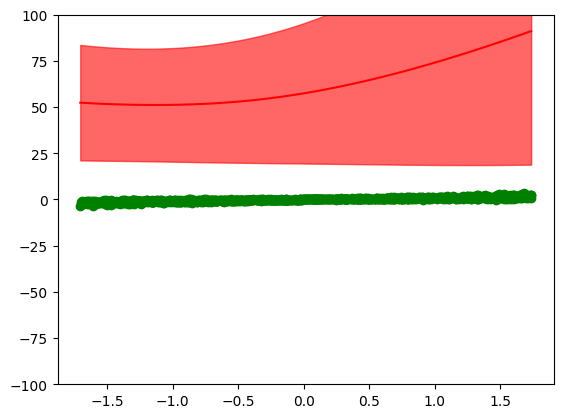

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [28]:
train_with_lr_reducer(model, batch_size=1000, lr_start=1, epochs=600)


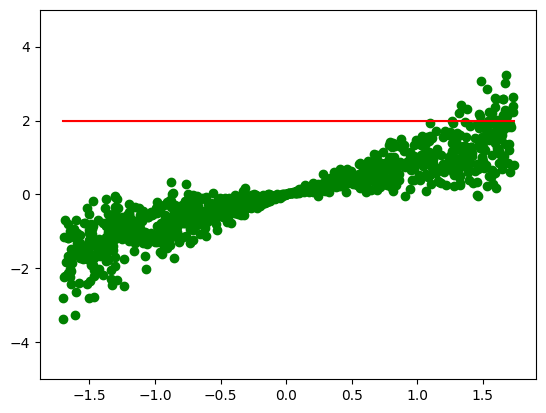

In [ ]:
plot_credibility_interval(model, X, y, y_min=-5, y_max=5, num_samples=100);